!!!!PLEASE READ!!!!
!!!!PLEASE READ!!!!
Remember to update scw01 to match your personal user directory! You received this user directory earlier, and you can also find it by opening the R terminal (bottom left of RStudio window, next to the Console tab).
mydir <- "/home1/scw01/"

## Load libraries and set user directory paths.

In [1]:
## https://stackoverflow.com/questions/70025153/how-to-access-the-shell-in-google-colab-when-running-the-r-kernel
shell_call <- function(command, ...) {
  result <- system(command, intern = TRUE, ...)
  cat(paste0(result, collapse = "\n"))
}

loadPackages = function(pkgs){
  myrequire = function(...){
    suppressWarnings(suppressMessages(suppressPackageStartupMessages(require(...))))
  }
  ok = sapply(pkgs, require, character.only=TRUE, quietly=TRUE)
  if (!all(ok)){
    message("There are missing packages: ", paste(pkgs[!ok], collapse=", "))
  }
}

## Setup R2U
download.file("https://github.com/eddelbuettel/r2u/raw/master/inst/scripts/add_cranapt_jammy.sh",
              "add_cranapt_jammy.sh")
Sys.chmod("add_cranapt_jammy.sh", "0755")
shell_call("./add_cranapt_jammy.sh")
bspm::enable()
options(bspm.version.check=FALSE)
shell_call("rm add_cranapt_jammy.sh")

## Install the R packages
cranPkgs2Install = c("dplyr", "ggpubr", "Seurat", "cowplot",
                     "Rtsne", "hdf5r", "patchwork")
install.packages(cranPkgs2Install, ask=FALSE, update=TRUE, quietly=TRUE)

50 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists...
Building dependency tree...
Reading state information...
wget is already the newest version (1.21.2-2ubuntu1).
ca-certificates is already the newest version (20230311ubuntu0.22.04.1).
gnupg is already the newest version (2.2.27-3ubuntu2.1).
gnupg set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 50 not upgraded.
-----BEGIN PGP PUBLIC KEY BLOCK-----

mQINBFM+sY8BEADA70T+U0/2WNjOTLvytuXLvBC4vgA8hYvOaBS1cL3d8lu4mwr4
W84/6p4v/mXle/0eIO2D2g+XfK72ZHZxpS+bb7yPxrkCDLGxwUd/khtTJHSbbKFo
J73AsABflMe+8qv+E74+QTiXErTCNioFRz18sa0EvOnEAiokau6TZVYY2z9YjBNI
yEjTi+z+g8c1RL6VmrFEpTicTpafOLbkRyw0VKnAKG7Ytp3Ksc1G9/IAoKw3Q9La
0DJb5iX6hyB7+PNid6htK4LtPKZ2dNSrnRvNNkjj5BgcM2AT1hmxbzHNzIVmPoKA
CQFrkdjog3/PcyjdtZG7cfoSDXrbIAZeAa2ngLv9C/DJatVDd6maPOe66gLo7+As
ErMvO9vtiouqLdurW+Lhx0jFW9Ca3g1taLfbSDyS3X1mOGWcisbQvBqkIuoDQTeS
V4Z04wrwTZ1HtweKG/s5fmPtZNGWVI5YNRLIwdmbGzFTMPu2XTAOd+xSK2H+46Kh
Sh4kFeP6p

Tracing function "install.packages" in package "utils"



In [2]:
## To simplify package loading, we created the loadPackages()
## function. But, if you don't have the function, you should
## use 'library(name_of_package)'
pkgs = c("Seurat", "dplyr","patchwork","ggplot2")
loadPackages(pkgs)
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# UPDATE scw01 DIRECTORY TO MATCH YOUR PERSONAL USER DIRECTORY. THIS IS WHERE YOU READ AND WRITE DATA.
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
mydir <- "/content"

‘SeuratObject’ was built under R 4.3.0 but the current version is
4.3.3; it is recomended that you reinstall ‘SeuratObject’ as the ABI
for R may have changed

‘SeuratObject’ was built with package ‘Matrix’ 1.6.3 but the current
version is 1.6.5; it is recomended that you reinstall ‘SeuratObject’ as
the ABI for ‘Matrix’ may have changed


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:base’:

    intersect



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In this lab we will be analyzing multi-modal data in which we measured RNA and protein expression levels in individual cells. We will follow a tutorial from Seurat ( see details here: https://satijalab.org/seurat/articles/multimodal_vignette.html)

The description of the sample from Seurat is here:
"Here, we analyze a dataset of 8,617 cord blood mononuclear cells (CBMCs), where transcriptomic measurements are paired with abundance estimates for 11 surface proteins, whose levels are quantified with DNA-barcoded antibodies. First, we load in two count matrices : one for the RNA measurements, and one for the antibody-derived tags (ADT)."

In [3]:
shell_call("wget ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE100nnn/GSE100866/suppl/GSE100866_CBMC_8K_13AB_10X-ADT_umi.csv.gz")
shell_call("wget ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE100nnn/GSE100866/suppl/GSE100866_CBMC_8K_13AB_10X-RNA_umi.csv.gz")

In [4]:
# Load in the RNA UMI matrix

# Note that this dataset also contains ~5% of mouse cells, which we can use as negative
# controls for the protein measurements. For this reason, the gene expression matrix has
# HUMAN_ or MOUSE_ appended to the beginning of each gene.
cbmc.rna <- as.sparse(read.csv(file = paste0(mydir,"/GSE100866_CBMC_8K_13AB_10X-RNA_umi.csv.gz"),sep=",",
    header = TRUE, row.names = 1))

# To make life a bit easier going forward, we're going to discard all but the top 100 most
# highly expressed mouse genes, and remove the 'HUMAN_' from the CITE-seq prefix
cbmc.rna <- CollapseSpeciesExpressionMatrix(cbmc.rna)

# Load in the ADT UMI matrix
cbmc.adt <- as.sparse(read.csv(file = paste0(mydir,"/GSE100866_CBMC_8K_13AB_10X-ADT_umi.csv.gz"),sep=",",
    header = TRUE, row.names = 1))

# Note that since measurements were made in the same cells, the two matrices have identical
# column names
all.equal(colnames(cbmc.rna), colnames(cbmc.adt))

[1] TRUE

In [5]:
# creates a Seurat object based on the scRNA-seq data
cbmc <- CreateSeuratObject(counts = cbmc.rna)

# We can see that by default, the cbmc object contains an assay storing RNA measurement
Assays(cbmc)

# create a new assay to store ADT information
adt_assay <- CreateAssayObject(counts = cbmc.adt)

# add this assay to the previously created Seurat object
cbmc[["ADT"]] <- adt_assay

# Validate that the object now contains multiple assays
Assays(cbmc)

# Extract a list of features measured in the ADT assay
rownames(cbmc[["ADT"]])

# Note that we can easily switch back and forth between the two assays to specify the default
# for visualization and analysis

# List the current default assay
DefaultAssay(cbmc)

# Switch the default to ADT
DefaultAssay(cbmc) <- "ADT"
DefaultAssay(cbmc)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


[1] "RNA"

[1] "RNA" "ADT"

[1] "CD3"    "CD4"    "CD8"    "CD45RA" "CD56"   "CD16"   "CD10"   "CD11c" 
 [9] "CD14"   "CD19"   "CD34"   "CCR5"   "CCR7"

[1] "RNA"

[1] "ADT"

# Clustering

[1] "RNA"

Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix

Computing nearest neighbor graph

Computing SNN

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
00:53:19 UMAP embedding parameters a = 0.9922 b = 1.112

00:53:19 Read 8617 rows and found 30 numeric columns

00:53:19 Using Annoy for neighbor search, n_neighbors = 30

00:53:19 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

00:53:21 Writing NN index file to temp file /tmp/RtmpGxnQQM/filea67c29c412

00:53:21 Searching Annoy index usi

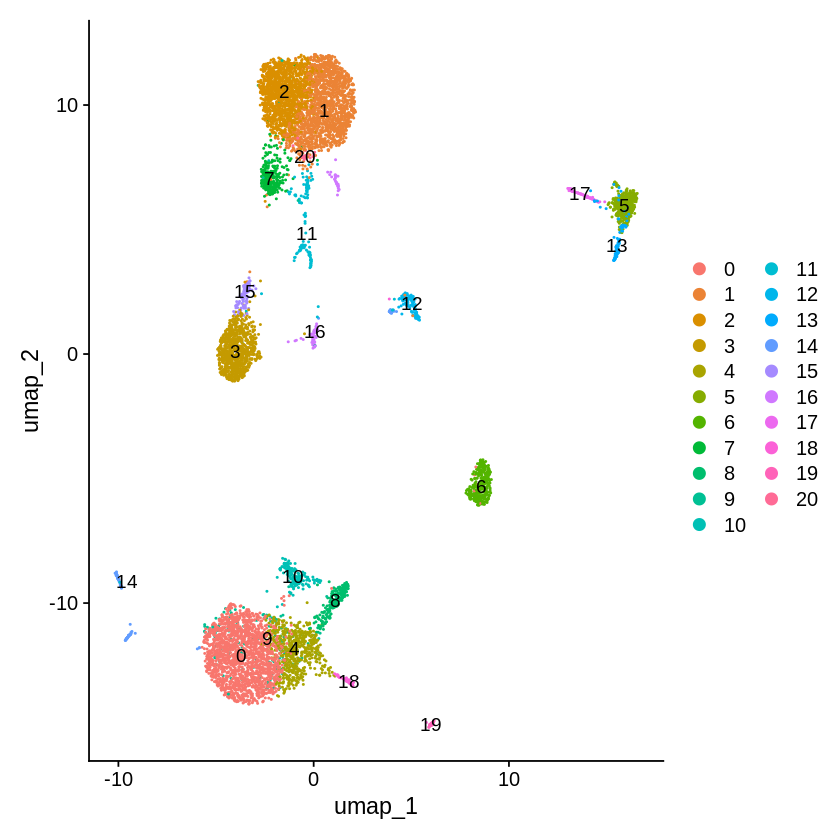

In [6]:
# Note that all operations below are performed on the RNA assay Set and verify that the
# default assay is RNA
DefaultAssay(cbmc) <- "RNA"
DefaultAssay(cbmc)

# perform visualization and clustering steps
cbmc <- NormalizeData(cbmc)
cbmc <- FindVariableFeatures(cbmc)
cbmc <- ScaleData(cbmc)
cbmc <- RunPCA(cbmc, verbose = FALSE)
cbmc <- FindNeighbors(cbmc, dims = 1:30)
cbmc <- FindClusters(cbmc, resolution = 0.8, verbose = FALSE)
cbmc <- RunUMAP(cbmc, dims = 1:30)
DimPlot(cbmc, label = TRUE)

# Visualize multiple modalities side-by-side
Now that we have obtained clusters from scRNA-seq profiles, we can visualize the expression of either protein or RNA molecules in our dataset. Importantly, Seurat provides a couple ways to switch between modalities, and specify which modality you are interested in analyzing or visualizing. This is particularly important as, in some cases, the same feature can be present in multiple modalities - for example this dataset contains independent measurements of the B cell marker CD19 (both protein and RNA levels).

Normalizing across cells

Normalizing across cells



[1] "rna_"

[1] "adt_"

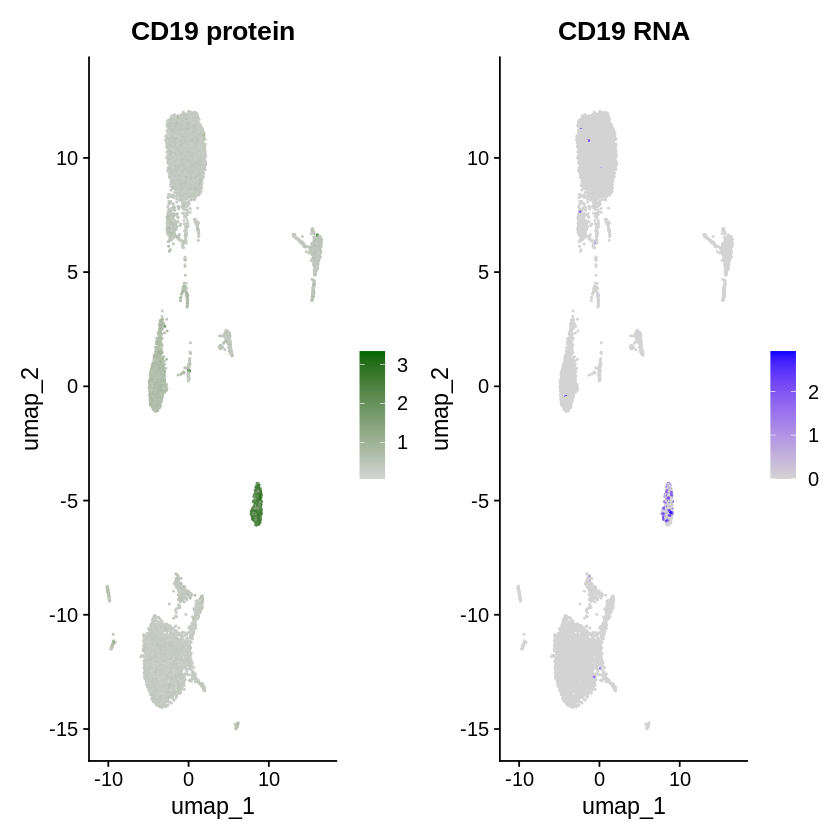

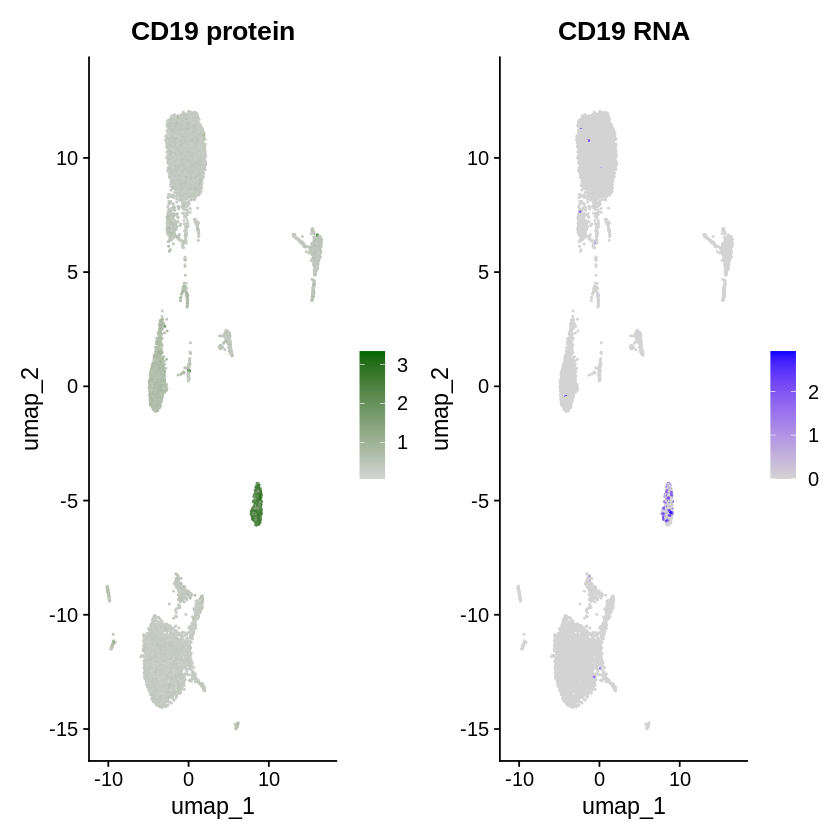

In [7]:
# Normalize ADT data,
DefaultAssay(cbmc) <- "ADT"
cbmc <- NormalizeData(cbmc, normalization.method = "CLR", margin = 2)
DefaultAssay(cbmc) <- "RNA"

# Note that the following command is an alternative but returns the same result
cbmc <- NormalizeData(cbmc, normalization.method = "CLR", margin = 2, assay = "ADT")

# Now, we will visualize CD14 levels for RNA and protein By setting the default assay, we can
# visualize one or the other
DefaultAssay(cbmc) <- "ADT"
p1 <- FeaturePlot(cbmc, "CD19", cols = c("lightgrey", "darkgreen")) + ggtitle("CD19 protein")
DefaultAssay(cbmc) <- "RNA"
p2 <- FeaturePlot(cbmc, "CD19") + ggtitle("CD19 RNA")

# place plots side-by-side
p1 | p2


# Alternately, we can use specific assay keys to specify a specific modality Identify the key
# for the RNA and protein assays
Key(cbmc[["RNA"]])
Key(cbmc[["ADT"]])

# Now, we can include the key in the feature name, which overrides the default assay
p1 <- FeaturePlot(cbmc, "adt_CD19", cols = c("lightgrey", "darkgreen")) + ggtitle("CD19 protein")
p2 <- FeaturePlot(cbmc, "rna_CD19") + ggtitle("CD19 RNA")
p1 | p2


# Identify cell surface markers for scRNA-seq clusters

For a (much!) faster implementation of the Wilcoxon Rank Sum Test,
(default method for FindMarkers) please install the presto package
--------------------------------------------
install.packages('devtools')
devtools::install_github('immunogenomics/presto')
--------------------------------------------
After installation of presto, Seurat will automatically use the more 
efficient implementation (no further action necessary).
This message will be shown once per session



,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CD19,2.067533e-215,2.5741873,1,1,2.687793e-214
CD45RA,8.106076e-109,0.5300346,1,1,1.053790e-107
CD4,1.123162e-107,-1.6707420,1,1,1.460110e-106
CD14,7.212876e-106,-1.0332070,1,1,9.376739e-105
CD3,1.639633e-87,-1.5823056,1,1,2.131523e-86
CCR5,2.552859e-63,0.3753989,1,1,3.318716e-62


,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
IGHM,0,6.660187,0.977,0.044,0
CD79A,0,6.748356,0.965,0.045,0
TCL1A,0,7.428099,0.904,0.028,0
CD79B,0,5.525568,0.944,0.089,0
IGHD,0,7.811884,0.857,0.015,0
MS4A1,0,7.523215,0.851,0.016,0


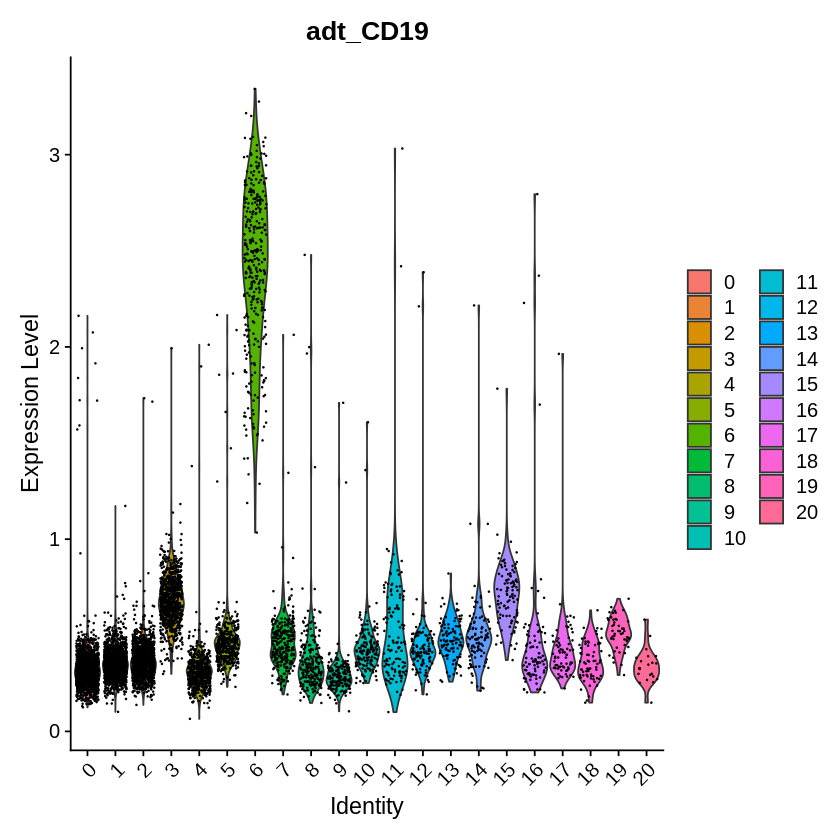

In [8]:
# as we know that CD19 is a B cell marker, we can identify cluster 6 as expressing CD19 on the
# surface
VlnPlot(cbmc, "adt_CD19")

# we can also identify alternative protein and RNA markers for this cluster through
# differential expression
adt_markers <- FindMarkers(cbmc, ident.1 = 6, assay = "ADT")
rna_markers <- FindMarkers(cbmc, ident.1 = 6, assay = "RNA")

head(adt_markers)
head(rna_markers)

# Additional visualizations of multimodal data

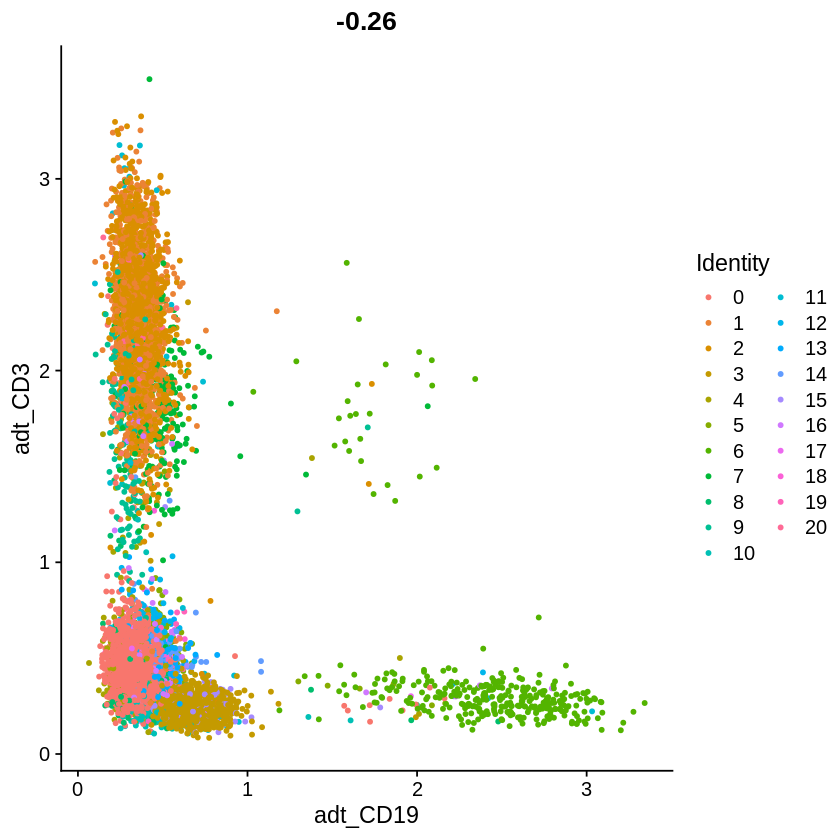

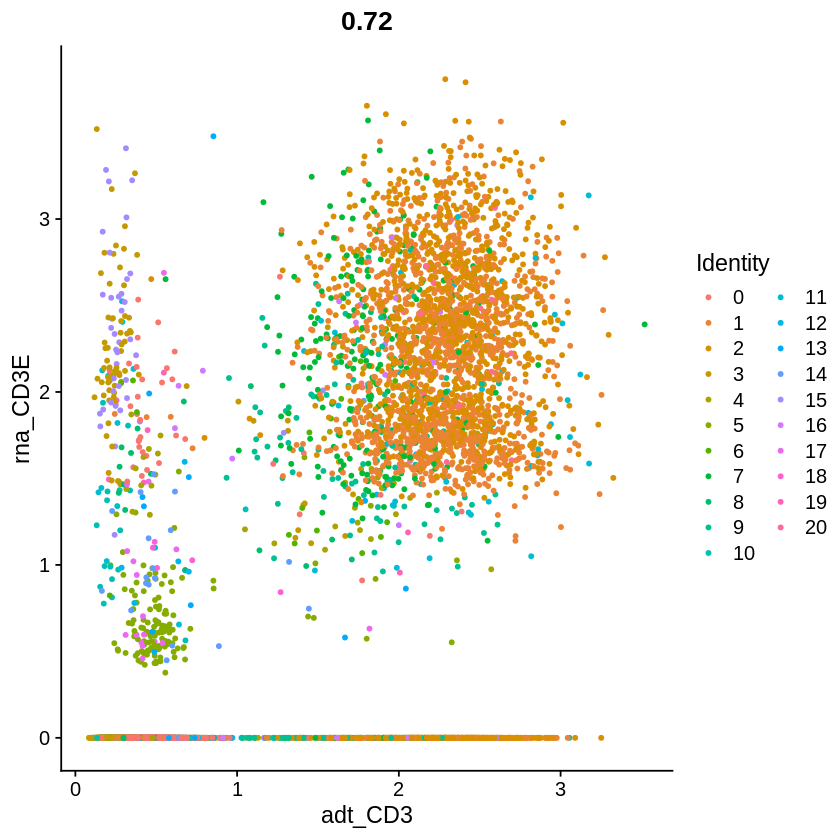

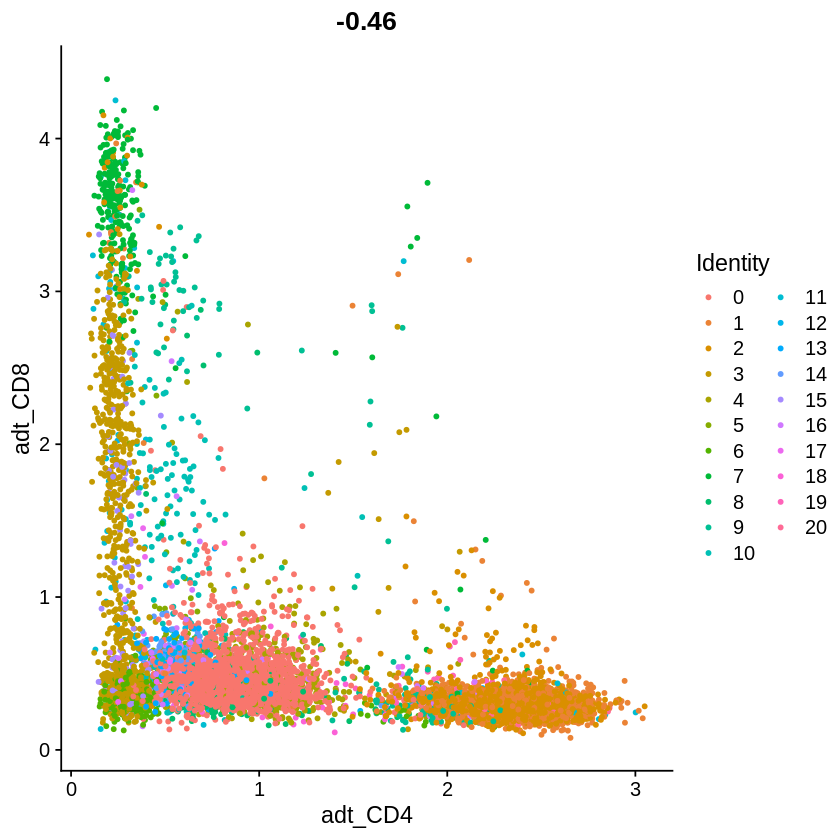

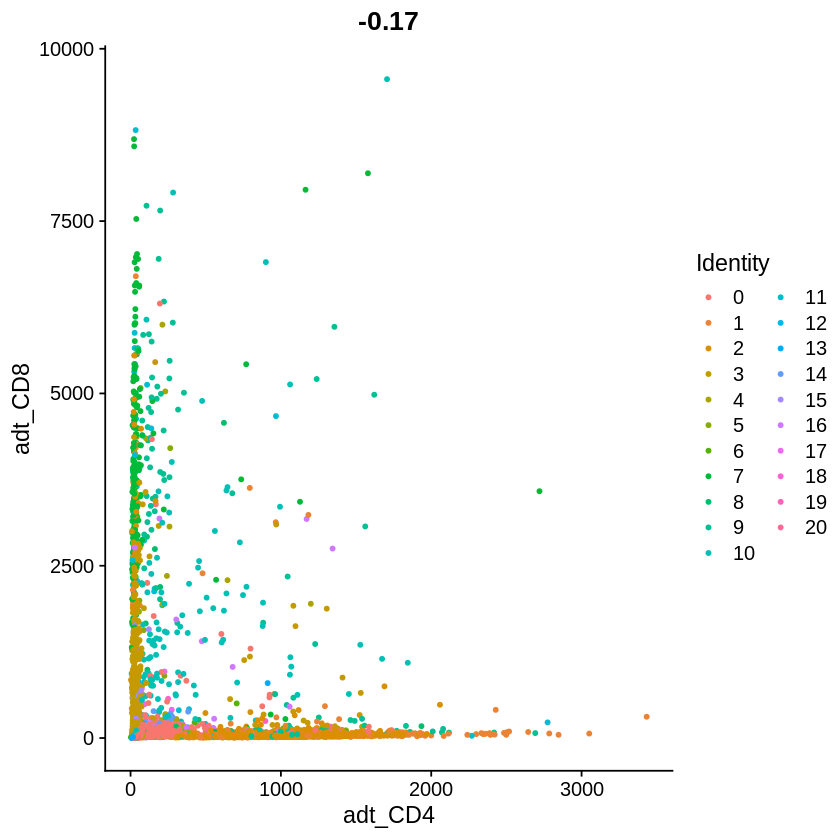

In [9]:
# Draw ADT scatter plots (like biaxial plots for FACS). Note that you can even 'gate' cells if
# desired by using HoverLocator and FeatureLocator
FeatureScatter(cbmc, feature1 = "adt_CD19", feature2 = "adt_CD3")

# view relationship between protein and RNA
FeatureScatter(cbmc, feature1 = "adt_CD3", feature2 = "rna_CD3E")

FeatureScatter(cbmc, feature1 = "adt_CD4", feature2 = "adt_CD8")

# Let's look at the raw (non-normalized) ADT counts. You can see the values are quite high,
# particularly in comparison to RNA values. This is due to the significantly higher protein
# copy number in cells, which significantly reduces 'drop-out' in ADT data
FeatureScatter(cbmc, feature1 = "adt_CD4", feature2 = "adt_CD8", slot = "counts")


# Loading data from 10X multi-modal experiments
NOTE: DO NOT RUN THIS SECTION
We are including it for you reference if you will need to process multi-modal 10x data from the raw data.

In [11]:

# Seurat is also able to analyze data from multimodal 10X experiments processed using CellRanger v3; as an example, we recreate the plots above using a dataset of 7,900 peripheral blood mononuclear cells (PBMC), freely available from 10X Genomics here.

pbmc10k.data <- Read10X(data.dir = "../data/pbmc10k/filtered_feature_bc_matrix/")
rownames(x = pbmc10k.data[["Antibody Capture"]]) <- gsub(pattern = "_[control_]*TotalSeqB", replacement = "",
    x = rownames(x = pbmc10k.data[["Antibody Capture"]]))

pbmc10k <- CreateSeuratObject(counts = pbmc10k.data[["Gene Expression"]], min.cells = 3, min.features = 200)
pbmc10k <- NormalizeData(pbmc10k)
pbmc10k[["ADT"]] <- CreateAssayObject(pbmc10k.data[["Antibody Capture"]][, colnames(x = pbmc10k)])
pbmc10k <- NormalizeData(pbmc10k, assay = "ADT", normalization.method = "CLR")

plot1 <- FeatureScatter(pbmc10k, feature1 = "adt_CD19", feature2 = "adt_CD3", pt.size = 1)
plot2 <- FeatureScatter(pbmc10k, feature1 = "adt_CD4", feature2 = "adt_CD8a", pt.size = 1)
plot3 <- FeatureScatter(pbmc10k, feature1 = "adt_CD3", feature2 = "CD3E", pt.size = 1)
(plot1 + plot2 + plot3) & NoLegend()


ERROR: Error in Read10X(data.dir = "../data/pbmc10k/filtered_feature_bc_matrix/"): Directory provided does not exist
